# Multi-Layer Perceptron (MLP)
This notebook builts an MLP for classification, same way as described in [Cepeda Humerez et al. (2019)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007290)

Hyperparameters to use:

````python
input_size = 200  # Adjust based on dataset
hidden_size = [300, 200] # 300 and 200 LTUs
output_size = 2  # Number of classes
dropout_rate = 0.5 # This wasn't specified in the paper, but choose any
learning_rate = 0.001 # Not specified in the paper
epochs = 100 # Not specified in the paper
batch_size = 16 # Not specified in the paper
````

The model architecture is in ``MLP.py``

Load the MLP model codes from ``src``

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
from sympy import sqrt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
from simulation.simulate_telegraph_model import *
from stats.report import *
from stats.autocorrelation import *
from visualisation.plots import *
from classifiers.svm_classifier import svm_classifier
from classifiers.random_classifier import random_classifier
from classifiers.logistic_regression_classifier import logistic_regression_classifier
from classifiers.random_forest_classifier import random_forest_classifier
from models.MLP import MLP 
from utils.set_seed import set_seed
from utils.load_data import load_and_split_data
import optuna
%load_ext autoreload
%autoreload 2

/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Example usage to train an MLP

In [3]:
# Example usage
input_size = 200  # Adjust based on dataset
hidden_size = [300, 200]
output_size = 2  # Number of classes
dropout_rate = 0.5
learning_rate = 0.001
epochs = 100
batch_size = 16

# Generate synthetic data
X_train = torch.randn(1000, input_size)
y_train = torch.randint(0, output_size, (1000,))
X_val = torch.randn(200, input_size)
y_val = torch.randint(0, output_size, (200,))

# Convert to DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize and train model
file_path = "mlp_model.pth"
model = MLP(input_size, hidden_size, output_size, dropout_rate, learning_rate)
history = model.train_model(train_loader, val_loader, epochs, save_path=file_path)

# Load best model and evaluate
model.load_model(file_path)
test_acc = model.evaluate(val_loader)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Make predictions
X_test = torch.randn(5, input_size)
predictions = model.predict(X_test)
print("Predicted classes:", predictions)

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.8790, Train Acc: 0.4730
Validation Acc: 0.4950
✅ Model saved at mlp_model.pth (Best Validation Acc: 0.4950)
Epoch [2/100], Loss: 1.4478, Train Acc: 0.5380
Validation Acc: 0.4500
No improvement (1/10).
Epoch [3/100], Loss: 1.0521, Train Acc: 0.5880
Validation Acc: 0.4750
No improvement (2/10).
Epoch [4/100], Loss: 0.9586, Train Acc: 0.6130
Validation Acc: 0.4900
No improvement (3/10).
Epoch [5/100], Loss: 0.8543, Train Acc: 0.6360
Validation Acc: 0.5050
✅ Model saved at mlp_model.pth (Best Validation Acc: 0.5050)
Epoch [6/100], Loss: 0.7486, Train Acc: 0.6380
Validation Acc: 0.4850
No improvement (1/10).
Epoch [7/100], Loss: 0.6732, Train Acc: 0.6720
Validation Acc: 0.5050
No improvement (2/10).
Epoch [8/100], Loss: 0.7137, Train Acc: 0.6450
Validation Acc: 0.5100
✅ Model saved at mlp_model.pth (Best Validation Acc: 0.5100)
Epoch [9/100], Loss: 0.5757, Train Acc: 0.7190
V

Train the MLP using SSA data, we need to first standardise the data. If we don't, the loss will be showing as nan, which is incorrect. 

In [2]:
# Train MLP model using SSA data
output_file = 'data/mRNA_trajectories_example.csv'
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(output_file, split_val_size=0.2) # we must define split_val_size here to get a validation set
print(X_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [3]:
# Standardize the data 
# If your input features are too large (e.g., >1000) or too small (<0.0001), it can cause unstable training, so it's better to standardize the data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print(X_train)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

[[ 0.         -0.40815408 -0.27320156 ... -0.06262243 -0.08873565
  -0.08873565]
 [ 0.         -0.40815408 -0.27320156 ... -0.06262243 -0.08873565
  -0.08873565]
 [ 0.          0.96668072 -0.27320156 ... -0.06262243 -0.08873565
  -0.08873565]
 ...
 [ 0.         -0.40815408 -0.27320156 ... -0.06262243 -0.08873565
  -0.08873565]
 [ 0.         -0.40815408 -0.27320156 ... -0.06262243 11.26942767
  -0.08873565]
 [ 0.         -0.40815408 -0.27320156 ... -0.06262243 -0.08873565
  -0.08873565]]
X_train shape: (256, 144)
y_train shape: (256,)


🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/1000], Loss: 1.2740, Train Acc: 0.5508
Validation Acc: 0.7031
Epoch [2/1000], Loss: 0.8994, Train Acc: 0.7031
Validation Acc: 0.6875
No improvement (1/10).
Epoch [3/1000], Loss: 0.7816, Train Acc: 0.7539
Validation Acc: 0.6875
No improvement (2/10).
Epoch [4/1000], Loss: 0.7404, Train Acc: 0.7617
Validation Acc: 0.6875
No improvement (3/10).
Epoch [5/1000], Loss: 0.5665, Train Acc: 0.7773
Validation Acc: 0.7344
Epoch [6/1000], Loss: 0.6121, Train Acc: 0.7305
Validation Acc: 0.6719
No improvement (1/10).
Epoch [7/1000], Loss: 0.6311, Train Acc: 0.7578
Validation Acc: 0.6719
No improvement (2/10).
Epoch [8/1000], Loss: 0.4116, Train Acc: 0.8281
Validation Acc: 0.6562
No improvement (3/10).
Epoch [9/1000], Loss: 0.4543, Train Acc: 0.8047
Validation Acc: 0.6406
No improvement (4/10).
Epoch [10/1000], Loss: 0.4588, Train Acc: 0.8086
Validation Acc: 0.7188
No improvement (5/10).
Epoch [11/1

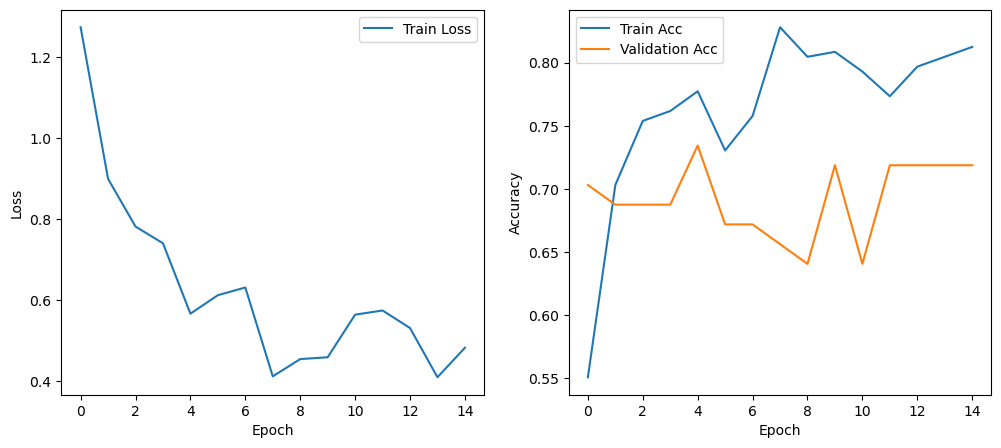

In [ ]:
set_seed(42)

# Define model parameters
input_size = X_train.shape[1]
# print(f"input_size: {input_size}")
output_size = len(set(y_train))  # Number of classes
hidden_size = [300, 200]
dropout_rate = 0.5
learning_rate = 0.001
epochs = 1000
batch_size = 32

train_loader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)),
    batch_size=batch_size, shuffle=True
)

val_loader = DataLoader(TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.long)),
    batch_size=batch_size, shuffle=False
)

test_loader = DataLoader(TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)),
    batch_size=batch_size, shuffle=False
)

model = MLP(input_size, hidden_size, output_size, dropout_rate, learning_rate)
history = model.train_model(train_loader, val_loader, epochs=epochs, patience=10)

# Evaluate MLP model
mlp_accuracy = model.evaluate(test_loader)
print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Same as above, but getting the accuracy in a one-liner

In [ ]:
# Train model using SSA data
output_file = 'data/mRNA_trajectories_example.csv'
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(output_file, split_val_size=0.2) # we must define split_val_size here to get a validation set
mlp_accuracy = mlp_classifier(X_train, X_val, X_test, y_train, y_val, y_test, epochs=100)

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 0.9696, Train Acc: 0.6641
Validation Acc: 0.6562
Epoch [2/100], Loss: 0.7469, Train Acc: 0.7422
Validation Acc: 0.6406
No improvement (1/10).
Epoch [3/100], Loss: 0.5988, Train Acc: 0.7852
Validation Acc: 0.6406
No improvement (2/10).
Epoch [4/100], Loss: 0.4658, Train Acc: 0.8008
Validation Acc: 0.7344
Epoch [5/100], Loss: 0.4959, Train Acc: 0.7773
Validation Acc: 0.6719
No improvement (1/10).
Epoch [6/100], Loss: 0.4065, Train Acc: 0.8125
Validation Acc: 0.6562
No improvement (2/10).
Epoch [7/100], Loss: 0.4356, Train Acc: 0.8047
Validation Acc: 0.6406
No improvement (3/10).
Epoch [8/100], Loss: 0.4291, Train Acc: 0.8008
Validation Acc: 0.6562
No improvement (4/10).
Epoch [9/100], Loss: 0.4436, Train Acc: 0.8086
Validation Acc: 0.7344
No improvement (5/10).
Epoch [10/100], Loss: 0.4074, Train Acc: 0.8008
Validation Acc: 0.6719
No improvement (6/10).
Epoch [11/100], Loss: